In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

In [61]:
# function that takes the dataframe with all the information we don't need, drops it, 
# and prints a spider graph. Also it saves the image to "graph.png"

# as this currently is, this function needs even the useless parts of our dataset 
# (especially song titles and artists names) to make the legend of the graph, so
# ideally dropping those things should occur after the graph is created.

def spider_plot(df_with_titles):
    
    categoricals = ['track_id', 'track_name', 'artist_name']
    misleading = ['key', 'time_signature', 'popularity', 'mode', 'tempo', 'duration_ms']

    unwanted = categoricals + misleading
    
    # number of variable
    df = df_with_titles.copy()
    df = df.drop(unwanted, 
                 axis=1)
    categories = df.columns
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    angles = np.array(angles)
    
    # Initialize the spider plot
    # set every background to be transparent
    fig = plt.figure(figsize=(9, 9), 
                     edgecolor='gray')
    fig.patch.set_facecolor('none')
    fig.patch.set_alpha(0.0)
    ax = fig.add_subplot(111, 
                         polar=True)
    ax.patch.set_facecolor('none')
    ax.patch.set_alpha(0.0)
    
    # Get the audio features of the inputed song and repeat the first value at the end
    # We need to repeat the first value in each row of the dataframe to close the circular graph:
    song_values = df.iloc[0].values.flatten().tolist()
    song_values += song_values[:1]
    # convert back to numpy array because we're going to be doing math later
    song_values = abs(np.array(song_values))
    
    
    # plot the Base song
    ax.plot(angles,
           song_values,
           linewidth=3,
           linestyle='solid',
           label=df_with_titles.iloc[0]['track_name'],
           color='limegreen',
           alpha=1)
    # fill the base song
    ax.fill(angles,
           song_values,
           color='lime',
           alpha=0.33)
    

    # for use in setting the maximum y limit
    maximum_diff = 0
    
    # set number of nearest neighbors that will appear on the graph
    num_neighbors = 3
    # "3" is currently how many of the top 9 closest songs we are choosing to show
    for i in range(num_neighbors):
        
        # Again repeat the first value in the array to close the circle
        # skipping the first row, because that's the target song
#         diff_values = df.iloc[i+1].values.flatten().tolist()
#         diff_values += diff_values[:1]
#         # convert back to numpy for math later on
#         diff_values = np.array(diff_values)
        
#         # do the math we told you we were doing to do
#         # this is the distance of each point from the user's chosen song
#         diff_values = abs(song_values - diff_values)
        
        # Again repeat the first value in the array to close the circle
        # skipping the first row, because that's the target song
        diff_values = df.iloc[i+1].values.flatten().tolist()
        diff_values += diff_values[:1]
        diff_values = abs(np.array(diff_values))
        
        colors=['b', 'r', 'orange', 'y', 'k', 'm', 'c', 'w', 'pink']
        # plot the recommendations
        ax.plot(angles, 
                diff_values, 
                linewidth=2, 
                linestyle='solid', 
                label=df_with_titles.iloc[i+1]['track_name'],
               color=colors[i])
        # fill the recommendations
        ax.fill(angles, 
                diff_values,
                color=colors[i],
                alpha=0)
        
        # check for new maximum y limit
        if max(diff_values) > maximum_diff:
            maximum_diff = max(diff_values)
        
    # Draw one axis per variable, add x labels
    plt.xticks(angles[:-1], 
               categories, 
               color='gray', 
               size=14)
    
    # Draw ylabels    
    # set theta position to 0
    ax.set_rlabel_position(22.5)
    # make the tick lengths (and label names since the lengths are the labels)
    yticks = [round(0.2 * maximum_diff, 2), 
              round(0.4 * maximum_diff, 2), 
              round(0.6 * maximum_diff, 2), 
              round(0.8 * maximum_diff, 2), 
              round(1.0 * maximum_diff, 2)]
    plt.yticks(yticks, 
               yticks, 
               color = 'gray', 
               fontsize=12)
    
    ax.spines['polar'].set_visible('False')
    # set maximum y limit to the largest prong of our web, 
    # that way the plot is exactly as big as it need to be, 
    # and no larger
    plt.ylim(0, 1.1 * maximum_diff)
    
    plt.title(f'Audio Features of your song (in bold) and our Recommendations for you', 
              color='grey')
    
    # show the plot
    ax.legend()
    fig.savefig('graph.png', 
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.show()
    
    return None

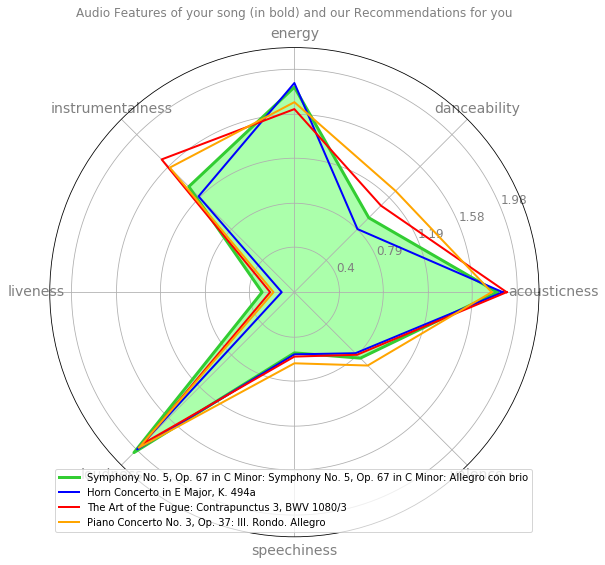

In [62]:
# example, just run this cell to see it work

# some data cleaning, merging csv's, dropping duplicate rows
S_2019 = pd.read_csv('SpotifyAudioFeaturesApril2019.csv')
S_2018 = pd.read_csv('SpotifyAudioFeaturesNov2018.csv')
df = pd.concat([S_2019, S_2018])
df = df.drop_duplicates()
# some entrees occur twice because they aren't quite duplicates,
# so we get rid of them
df = df.groupby(by=['track_id', 'track_name', 'artist_name']).mean()
df = df.reset_index()

# normalize dataset, our model likes normalized data
numeric_cols = df.select_dtypes(include=np.number).columns
df_num = df.select_dtypes(include=np.number)
df_norm = df.copy()
df_norm[numeric_cols] = (df_num - df_num.mean()) / df_num.std()


# make and fit the model
from sklearn.neighbors import NearestNeighbors

# drop unuseable or unnessecary columns
categoricals = ['track_id', 'track_name', 'artist_name']
misleading = ['key', 'time_signature', 'popularity', 'mode', 'tempo', 'duration_ms']

unwanted = categoricals + misleading

# get names of columns we are going to use into a single list
features = [col for col in df_norm.columns if col not in unwanted]

# fit the model to those columns
Model = NearestNeighbors(n_neighbors=10).fit(df_norm[features])


# pick a song in the dataset to use as a test
song_index = 3679
test_row = df_norm.iloc[song_index][features]
test_song = test_row.to_numpy()

# indexes of the nearest neighbors
recommend = Model.kneighbors(test_song.reshape(1,-1))[1][0]


# call the graphing function
spider_plot(df_norm.iloc[recommend])